In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from math import radians, cos, sin, asin, sqrt
import collections
import time
import random
from sklearn.metrics import roc_auc_score, silhouette_score, roc_curve
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


## helper functions and classes to make code in notebook cleaner
from helper import *
%load_ext autoreload
%autoreload 2

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
random_seed = 42
max_distance_from_median_lat_lon_per_msa = 300
path_to_data = "RevelioLabs_LocationSample_Nov22.csv"

In [3]:
df = pd.read_csv(path_to_data).rename(columns={'Unnamed: 0':'old_index'})
df['msa'] = df['msa'].replace({'Tampa-St. Petersburg-Clearwater FL': 'Tampa-St. Petersburg-Clearwater FL MSA'})

usa = df[df.country == 'united states']
other_countries = df[df.country != 'united states']

# Clean MSAs
train_df = create_clean_labels(usa, max_distance_from_median_lat_lon_per_msa, haversine)

print(sum(train_df.msa.isna()))

Examples split into labels and all example accounted for
0


Here we construct the population and population density related features. See `helper.py` for code (`get_feature_map` and `calculate_features`). Code is admittedly not optimized or clean (due to time constraints). List of features:
- Population within `[1,2,5,10,20,30,50,100]` miles
- Number of cities within `[1,2,5,10,20,30,50,100]` miles
- Number of cities with population `>= [10k, 50k, 100k]` within `[1,2,5,10,20,30,50,100]` miles

In [4]:
feature_map = get_feature_map(train_df)
calculate_features(train_df, feature_map)

In [5]:
train_df_vf = train_df[['lat_lon','label']].set_index('lat_lon')
train_df_vf = train_df_vf.join(pd.DataFrame(feature_map).T, on='lat_lon')
train_df_vf

,label,total_population_1mi,total_population_2mi,total_population_5mi,total_population_10mi,total_population_20mi,total_population_30mi,total_population_50mi,total_population_100mi,total_num_cities_1mi,...,total_num_cities_w_pop_gt_50k_50mi,total_num_cities_w_pop_gt_50k_100mi,total_num_cities_w_pop_gt_10k_1mi,total_num_cities_w_pop_gt_10k_2mi,total_num_cities_w_pop_gt_10k_5mi,total_num_cities_w_pop_gt_10k_10mi,total_num_cities_w_pop_gt_10k_20mi,total_num_cities_w_pop_gt_10k_30mi,total_num_cities_w_pop_gt_10k_50mi,total_num_cities_w_pop_gt_10k_100mi
lat_lon,,,,,,,,,,,,,,,,,,,,,
"39.64452,-80.8576",0,5218,5218,5218,5218,13928,41576,216910,1663883,1,...,0,2,0,0,0,0,0,1,8,45
"38.05289,-81.10399",0,2892,2892,2892,11032,28088,32777,123353,636795,1,...,0,1,0,0,0,0,1,1,3,15
"35.17008,-88.59227",0,4488,4488,4488,4488,26381,26381,136541,1489513,1,...,1,4,0,0,0,0,1,1,2,25
"43.44536,-71.47785",0,1301,1301,1301,37439,86059,176147,735754,6037954,1,...,2,23,0,0,0,1,2,3,17,126
"59.23595,-135.44533",0,1713,1713,1713,1713,2633,2633,2633,35823,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"34.76591,-84.76994",1,4351,4351,4351,4351,39884,64840,363543,2540857,1,...,1,9,0,0,0,0,1,2,7,52
"34.7698,-84.97022",1,33853,33853,33853,33853,41904,247762,330786,2387763,1,...,1,8,1,1,1,1,1,3,6,49
"32.61574,-83.62664",1,73490,73490,73490,78595,194000,200319,248523,1689401,1,...,2,5,1,1,1,1,3,3,5,32


In [6]:
## Checked in excel to make sure certain inequalities between features held (it passed the tests)
train_df_vf.to_csv("sanity_checking_feature_calc.csv")

Let's make train / test set. The test set will be saved for evaluation. No tuning or any analysis is done using it. We will split the train into train / val sets to tune some parameters later

In [7]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    train_df_vf.drop(columns='label'),
    train_df_vf.label,
    test_size=0.1,
    random_state=random_seed,
    shuffle=True
)

### Saving the test data, will run hyper parameter search on google colab for GPU usage with XGBoost
- Link: https://colab.research.google.com/drive/1cW25sDRNIpK7Z1m2pGTnNO3POOsNaeyM?usp=sharing

In [8]:
X_train.to_csv("X_train.csv")
y_train.to_csv("y_train.csv")

### We are done hyperparameter tuning. Let's now choose the best threshold for the classifiers. We will split the training data into train, val data 20 times and see which thresholds do well on the validation set using 2 methods:
- Max the geometric mean of sensitivity and specificity (mathematical approach to balance sensitivity and specificity)
- Over 20 runs see which threshold gives best `accuracy` in each run, then average over the 20 runs

In [9]:
params_xgb = {
    'max_depth': 6,
    'n_estimators': 100,
    'eta':0.1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 0.9
}

best_thresholds_custom_xgb = []
best_thresholds_gmeans_xgb = []
for i in range(20):
    random_seed = i
    X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
        X_train, 
        y_train,
        test_size=0.1,
        random_state=random_seed,
        shuffle=True
    )


    xgb = XGBClassifier(n_jobs=-1, verbosity=0, **params_xgb)
    xgb.fit(X_train_c, y_train_c)
    
    best_threshold_custom_xgb = get_best_threshold_custom(X_val_c, y_val_c, xgb)
    gmean_best_threshold_xgb = get_best_threshold_gmeans(X_val_c, y_val_c, xgb, roc_curve)
    
    best_thresholds_custom_xgb.append(best_threshold_custom_xgb)
    best_thresholds_gmeans_xgb.append(gmean_best_threshold_xgb)

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option

In [10]:
np.mean(best_thresholds_custom_xgb), np.std(best_thresholds_custom_xgb)

(0.465, 0.07221495689952326)

In [11]:
np.mean(best_thresholds_gmeans_xgb), np.std(best_thresholds_gmeans_xgb)

(0.70804995, 0.07717332)

Let's do it for baseline LR model now

In [12]:
params_lr = {
    'penalty':'l1', 
    'solver':'liblinear'
}

best_thresholds_custom_lr = []
best_thresholds_gmeans_lr = []
for i in range(20):
    random_seed = i
    X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
        X_train, 
        y_train,
        test_size=0.1,
        random_state=random_seed,
        shuffle=True
    )

    lr = LogisticRegression(**params_lr)
    lr.fit(X_train_c, y_train_c)
    
    best_threshold_custom_lr = get_best_threshold_custom(X_val_c, y_val_c, lr)
    gmean_best_threshold_lr = get_best_threshold_gmeans(X_val_c, y_val_c, lr, roc_curve)
    
    best_thresholds_custom_lr.append(best_threshold_custom_lr)
    best_thresholds_gmeans_lr.append(gmean_best_threshold_lr)

In [13]:
np.mean(best_thresholds_custom_lr), np.std(best_thresholds_custom_lr)

(0.492, 0.03009983388658483)

In [14]:
np.mean(best_thresholds_gmeans_lr), np.std(best_thresholds_gmeans_lr)

(0.58866, 0.032423824573914795)

For xgboost, we choose a threshold = 0.6. This is because the first approach to maximize accuracy had an average threshold of  0.465 but the threshold that maximizes geometric mean of sensitivity and specificity is > 0.7. Both approaches have roughly the same variance in results so we choose somewhere in the middle.

For baseline logistic regression, we'll follow roughly the same logic and set threshold to 0.55

## Let's now evaluate how well our models discriminate between MSA and non metropolitan areas

- We will retrain the models on the full train set and measure perforrmance on unseen test set data (made in cell 7)
- Caveat: the models are highly biased toward MSA structures in the US and we're measuring performance on the USA so we truly don't know how it will perform in countries with urban planning and population patterns dissimilar to the US. A positive note is that the US has a decent variety of metropolitan areas (highly dense and high population like NYC) and more spread out metro areas so we have hope that our model can generalize. We note also note that we have limited data and this project has limited scope so this is a decent solution for now.

In [15]:
test_random_seed = 100
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
xgb = XGBClassifier(
    n_jobs=-1, 
    verbosity=0, 
    random_state=test_random_seed, 
    **params_xgb
)
xgb.fit(X_train, y_train)

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [16]:
threshold_opt_xgb = 0.6
threshold_opt_lr = 0.55

pred_proba = xgb.predict_proba(X_test)[:,1]
xgb_preds = (pred_proba >= threshold_opt_xgb).astype(int)

print(f"Test set accuracy for XGBoost: {np.mean(xgb_preds == y_test)}")
print(f"Test set ROC AUC for XGBoost: {roc_auc_score(y_test, pred_proba)}")

Test set accuracy for XGBoost: 0.8818897637795275
Test set ROC AUC for XGBoost: 0.9165906912593216


In [17]:
pred_proba = lr.predict_proba(X_test)[:,1]
lr_preds = (pred_proba >= threshold_opt_lr).astype(int)
print(f"Test set accuracy for Baseline Logistic Regression with L1 penalty: {np.mean(lr_preds == y_test)}")
print(f"Test set ROC AUC for Baseline Logistic Regression with L1 penalty: {roc_auc_score(y_test, pred_proba)}")

Test set accuracy for Baseline Logistic Regression with L1 penalty: 0.8440944881889764
Test set ROC AUC for Baseline Logistic Regression with L1 penalty: 0.8817355120742456


Although not monumental, the XGBoost model does have a better accuracy than the Logistic Regression model as well as better class separation ability overall.

Let's have a glimpse into type 1 and type 2 error as well as how large of a population we misclassified. We will join the predictions onto the test set and do computations using pandas

In [18]:
pred_join = y_test.to_frame()
pred_join['xgb_preds'] = xgb_preds
pred_join['lr_preds'] = lr_preds
merged_test_df = pd.merge(pred_join, train_df, how='inner', on='lat_lon')

In [19]:
type1_error_df_xgb = merged_test_df[(merged_test_df.label_x == 0) & (merged_test_df.xgb_preds == 1)]
print(f"False positive rate with XGBoost: {len(type1_error_df_xgb) / np.sum(merged_test_df.label_x == 0)}")
print(f"{type1_error_df_xgb.population.sum()} people were false positives (bad estimate but only one we have)")

False positive rate with XGBoost: 0.23195876288659795
651318 people were false positives (bad estimate but only one we have)


In [20]:
type2_error_df_xgb = merged_test_df[(merged_test_df.label_x == 1) & (merged_test_df.xgb_preds == 0)]
print(f"False negative rate with XGBoost: {len(type2_error_df_xgb) / merged_test_df.label_x.sum()}")
print(f"{type2_error_df_xgb.population.sum()} people were false negatives (bad estimate but only one we have)")

False negative rate with XGBoost: 0.06802721088435375
301972 people were false negatives (bad estimate but only one we have)


In [21]:
type1_error_df_lr = merged_test_df[(merged_test_df.label_x == 0) & (merged_test_df.lr_preds == 1)]
print(f"False positive rate with logistic regression: {len(type1_error_df_lr) / np.sum(merged_test_df.label_x == 0)}")
print(f"{type1_error_df_lr.population.sum()} people were false positives (bad estimate but only one we have)")

False positive rate with logistic regression: 0.18556701030927836
551250 people were false positives (bad estimate but only one we have)


In [22]:
type2_error_df_lr = merged_test_df[(merged_test_df.label_x == 1) & (merged_test_df.lr_preds == 0)]
print(f"False negative rate with logistic regression: {len(type2_error_df_lr) / merged_test_df.label_x.sum()}")
print(f"{type2_error_df_lr.population.sum()} people were false negatives (bad estimate but only one we have)")

False negative rate with logistic regression: 0.14285714285714285
525423 people were false negatives (bad estimate but only one we have)


## XGBoost has better performance all around by most metrics and views into the test set.  There are some caveats but we will go ahead with the XGBoost model for now and cluster all of the model-predicted metropolitan cities into specific MSA groups
- XGBoost does not have a better false positive rate but from inspection, the XGBoost model was not making unreasonable errors
- We will use the (country / state) to denote a city's groupings if the city is predicted to not be in an MSA

In [23]:
cluster_df_container = [] # container to hold all processed dataframes to glue together after clustering / processing
max_distance = 50
relevant_cols = ['latitude','longitude', 'population']
max_iters = 500

We will remove some examples that are pure repeats and then add them back in after clustering is completed

In [24]:
## Repeat examples below:
df[df.old_index.isin([17114,21876,28596])]

,old_index,city,state,country,latitude,longitude,population,msa
13222,17114,llavallol,buenos aires,argentina,-34.7667,-58.3833,0,NaN
16929,21876,seri kembangan,selangor,malaysia,3.0333,101.7167,0,NaN
22471,28596,amerika,saxony,germany,50.7000,12.5167,0,NaN


In [25]:
df_no_repeats = df[~df.old_index.isin([17114,21876,28596])].copy()
df_no_repeats

,old_index,city,state,country,latitude,longitude,population,msa
0,0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...
1,1,seven hills,ohio,united states,41.39533,-81.67624,11690,NaN
2,2,new martinsville,west virginia,united states,39.64452,-80.85760,5218,WV NONMETROPOLITAN AREA
3,3,sint anthonis,north brabant,netherlands,51.62667,5.88194,3340,NaN
4,4,machali,o higgins region,chile,-34.18082,-70.64933,27595,NaN
...,...,...,...,...,...,...,...,...
25405,32094,mansfield,texas,united states,32.56319,-97.14168,64274,Mansfield OH MSA
25406,32095,belfast,maine,united states,44.42591,-69.00642,6682,ME NONMETROPOLITAN AREA
25407,32096,flushing,michigan,united states,43.06308,-83.85107,8086,Wheeling WV-OH MSA
25408,32097,stone mountain,georgia,united states,33.80816,-84.17020,6109,Atlanta-Sandy Springs-Marietta GA MSA


### Quick data fix and check in order to uniquely identify a row with country + state + city combination

In [26]:
df_no_repeats['state'] = df_no_repeats['state'].fillna("no state association")
(df_no_repeats.country + "," + df_no_repeats.state + "," + df_no_repeats.city).nunique() == len(df_no_repeats)

True

Running my custom clustering. This will take at least 10 - 15 minutes on a reasonably high powered single machine. Note again that the cities predicted to not be in an MSA will be categorized as `countryName__stateName__NONMETROPOLITAN AREA`. MSA clusters will be identified by `countryName__stateName__representativeCityName__MSA` where `representativeCityName` is the largest population city (aka representative in union find algorithm / data structure) of a cluster.

In [27]:
for country in df_no_repeats.country.unique():
    
    start = time.time()
    
    # Filter for a specific country
    country_df = df_no_repeats[df_no_repeats.country == country].reset_index().copy()
    print(f"On {country} with {len(country_df)} entries")
    
    # Feature calculation uses concat(lat, lon) as the identifier for a row
    country_df['lat_lon'] = country_df.latitude.astype(str) + \
                            "," + \
                            country_df.longitude.astype(str)
    feature_map = get_feature_map(country_df)
    
    calculate_features(country_df, feature_map)
    print(f"Done making features for {country}. {time.time() - start} seconds have elapsed")
    
    # Prepare X dataframe for inference
    inference_df = country_df[['lat_lon']].set_index('lat_lon').copy()
    inference_df = inference_df.join(pd.DataFrame(feature_map).T, on='lat_lon')
    
    pred_proba = xgb.predict_proba(inference_df)[:,1]
    inference_df['pred'] = (pred_proba >= threshold_opt_xgb).astype(int)
    
    preds_df = pd.merge(inference_df[['pred']], country_df, on='lat_lon').copy()
    
    # Separate metro from non metro since we only apply special clustering to former
    metro_areas = preds_df[preds_df.pred == 1].copy().reset_index()
    non_metro_areas = preds_df[preds_df.pred == 0].copy().reset_index()
    
    # Basic checks to ensure data is correct
    assert (np.sum((metro_areas.latitude.astype(str) + "," + metro_areas.longitude.astype(str))
                   == metro_areas.lat_lon) == len(metro_areas))
    assert (np.sum((non_metro_areas.latitude.astype(str) + "," + non_metro_areas.longitude.astype(str))
                   == non_metro_areas.lat_lon) == len(non_metro_areas))
    
    populations = metro_areas.population.to_list()
    
    # Run custom clustering algorithm
    adj_list, max_pop_per_city_id = get_adj_list_and_best_representative(max_distance, metro_areas[relevant_cols])
    
    uf = get_clusters(max_iters, adj_list, populations, max_pop_per_city_id)
    
    # Clustering done, now map cluster numbers back to representative city name
    msa_ids_df = metro_areas.iloc[uf.root][['country','state','city']].copy()
    msa_ids = msa_ids_df.country + "__" + msa_ids_df.state + "__" + msa_ids_df.city + "__MSA"
    
    metro_areas['new_msa'] = msa_ids.to_list()
    cluster_df_container.append(metro_areas)
    
    # Assign non metro cities to the country, state
    non_metro_areas['new_msa'] = (non_metro_areas['country'] + "__" + 
                                  non_metro_areas['state'] + 
                                  "__NONMETROPOLITAN AREA")
    cluster_df_container.append(non_metro_areas)
    
    print(f"{time.time() - start} total seconds for {country} with {len(uf.root)} MSA entries clustered, {len(preds_df)} total entries processed")

On united states with 7484 entries
Done making features for united states. 258.316531419754 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 30
470.47555589675903 total seconds for united states with 5545 MSA entries clustered, 7484 total entries processed
On netherlands with 965 entries
Done making features for netherlands. 7.1049394607543945 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 4
11.944830179214478 total seconds for netherlands with 965 MSA entries clustered, 965 total entries processed
On chile with 120 entries
Done making features for chile. 0.07993793487548828 seconds have elapsed
Terminated on iteration 4
0.17327880859375 total seconds for chile with 95 MSA entries clustered, 120 total entries processed
On poland with 252 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for poland. 0.37711596488952637 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 11
0.7769513130187988 total seconds for poland with 241 MSA entries clustered, 252 total entries processed
On denmark with 241 entries
Done making features for denmark. 0.390017032623291 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 6
0.6401333808898926 total seconds for denmark with 188 MSA entries clustered, 241 total entries processed
On spain with 682 entries
Done making features for spain. 2.2416231632232666 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 13
4.092828273773193 total seconds for spain with 623 MSA entries clustered, 682 total entries processed
On united kingdom with 1398 entries
Done making features for united kingdom. 10.773151636123657 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 12
19.84716272354126 total seconds for united kingdom with 1338 MSA entries clustered, 1398 total entries processed
On switzerland with 396 entries
Done making features for switzerland. 1.0399343967437744 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 4
1.73970627784729 total seconds for switzerland with 373 MSA entries clustered, 396 total entries processed
On australia with 1006 entries
Done making features for australia. 4.730022668838501 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 3
6.990084648132324 total seconds for australia with 758 MSA entries clustered, 1006 total entries processed
On bangladesh with 31 entries
Done making features for bangladesh. 0.01027536392211914 seconds have elapsed
Terminated on iteration 4
0.03986001014709473 total seconds for bangladesh with 31 MSA entries clustered, 31 total entries processed
On norway with 146 entries
Done making features for norway. 0.15036439895629883 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 3
0.223952054977417 total seconds for norway with 80 MSA entries clustered, 146 total entries processed
On italy with 1114 entries
Done making features for italy. 6.136459589004517 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 15
13.326544046401978 total seconds for italy with 1022 MSA entries clustered, 1114 total entries processed
On germany with 978 entries
Done making features for germany. 4.975064277648926 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 17
11.910002946853638 total seconds for germany with 953 MSA entries clustered, 978 total entries processed
On canada with 616 entries
Done making features for canada. 1.7250988483428955 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 4
2.3798441886901855 total seconds for canada with 354 MSA entries clustered, 616 total entries processed
On austria with 126 entries
Done making features for austria. 0.10837817192077637 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 4
0.2163984775543213 total seconds for austria with 91 MSA entries clustered, 126 total entries processed
On japan with 55 entries
Done making features for japan. 0.03308558464050293 seconds have elapsed
Terminated on iteration 2
0.08808565139770508 total seconds for japan with 52 MSA entries clustered, 55 total entries processed
On south korea with 31 entries
Done making features for south korea. 0.02500009536743164 seconds have elapsed
Terminated on iteration 3
0.06768488883972168 total seconds for south korea with 31 MSA entries clustered, 31 total entries processed
On russia with 82 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for russia. 0.08088302612304688 seconds have elapsed
Terminated on iteration 1
0.1842043399810791 total seconds for russia with 75 MSA entries clustered, 82 total entries processed
On france with 2341 entries
Done making features for france. 30.628166437149048 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 22
87.12376046180725 total seconds for france with 2005 MSA entries clustered, 2341 total entries processed
On india with 868 entries
Done making features for india. 3.1770217418670654 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 12
5.93010139465332 total seconds for india with 824 MSA entries clustered, 868 total entries processed
On portugal with 219 entries
Done making features for portugal. 0.2702338695526123 seconds have elapsed
Terminated on iteration 4
0.4604182243347168 total seconds for portugal with 156 MSA entries clustered, 219 total entries processed
On sweden with 353 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for sweden. 0.6547656059265137 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 10
0.929572343826294 total seconds for sweden with 199 MSA entries clustered, 353 total entries processed
On belgium with 447 entries
Done making features for belgium. 1.5761127471923828 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 3
2.585310459136963 total seconds for belgium with 437 MSA entries clustered, 447 total entries processed
On hungary with 53 entries
Done making features for hungary. 0.024741649627685547 seconds have elapsed
Terminated on iteration 5
0.058856964111328125 total seconds for hungary with 49 MSA entries clustered, 53 total entries processed
On finland with 95 entries
Done making features for finland. 0.09099626541137695 seconds have elapsed
Terminated on iteration 4
0.14082884788513184 total seconds for finland with 49 MSA entries clustered, 95 total entries processed

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



On kenya with 35 entries
Done making features for kenya. 0.023889541625976562 seconds have elapsed
Terminated on iteration 2
0.05996417999267578 total seconds for kenya with 25 MSA entries clustered, 35 total entries processed
On ireland with 109 entries
Done making features for ireland. 0.14510297775268555 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 2
0.2300121784210205 total seconds for ireland with 68 MSA entries clustered, 109 total entries processed
On china with 223 entries
Done making features for china. 0.32033681869506836 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 5
0.6128110885620117 total seconds for china with 212 MSA entries clustered, 223 total entries processed
On papua new guinea with 7 entries
Done making features for papua new guinea. 0.0025434494018554688 seconds have elapsed
Terminated on iteration 1
0.022144794464111328 total seconds for papua new guinea with 2 MSA entries clustered, 7 total entries processed
On philippines with 144 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for philippines. 0.20544648170471191 seconds have elapsed
Terminated on iteration 5
0.37119340896606445 total seconds for philippines with 127 MSA entries clustered, 144 total entries processed
On armenia with 7 entries
Done making features for armenia. 0.004039287567138672 seconds have elapsed
Terminated on iteration 2


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.031737565994262695 total seconds for armenia with 7 MSA entries clustered, 7 total entries processed
On mexico with 323 entries
Done making features for mexico. 0.6475505828857422 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 8
1.100888729095459 total seconds for mexico with 292 MSA entries clustered, 323 total entries processed
On thailand with 57 entries
Done making features for thailand. 0.026429414749145508 seconds have elapsed
Terminated on iteration 2
0.06154680252075195 total seconds for thailand with 43 MSA entries clustered, 57 total entries processed
On brazil with 952 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for brazil. 3.9449918270111084 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 29
6.800575256347656 total seconds for brazil with 758 MSA entries clustered, 952 total entries processed
On lebanon with 23 entries
Done making features for lebanon. 0.004076480865478516 seconds have elapsed
Terminated on iteration 1
0.029406309127807617 total seconds for lebanon with 23 MSA entries clustered, 23 total entries processed
On indonesia with 279 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for indonesia. 0.42804765701293945 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 8
0.8159222602844238 total seconds for indonesia with 263 MSA entries clustered, 279 total entries processed
On nigeria with 99 entries
Done making features for nigeria. 0.05597329139709473 seconds have elapsed
Terminated on iteration 4
0.13879609107971191 total seconds for nigeria with 86 MSA entries clustered, 99 total entries processed
On malawi with 6 entries
Done making features for malawi. 0.005014657974243164 seconds have elapsed
Terminated on iteration 1
0.03008580207824707 total seconds for malawi with 4 MSA entries clustered, 6 total entries processed
On new zealand with 97 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for new zealand. 0.10998296737670898 seconds have elapsed
Terminated on iteration 3
0.18068408966064453 total seconds for new zealand with 57 MSA entries clustered, 97 total entries processed
On czechia with 103 entries
Done making features for czechia. 0.12433886528015137 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 6
0.2493436336517334 total seconds for czechia with 94 MSA entries clustered, 103 total entries processed
On congo with 4 entries
Done making features for congo. 0.00603175163269043 seconds have elapsed
Terminated on iteration 1
0.03009963035583496 total seconds for congo with 3 MSA entries clustered, 4 total entries processed
On algeria with 52 entries
Done making features for algeria. 0.049672603607177734 seconds have elapsed
Terminated on iteration 4
0.11475491523742676 total seconds for algeria with 50 MSA entries clustered, 52 total entries processed
On mauritius with 24 entries
Done making features for mauritius. 0.02510833740234375 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 1
0.07055258750915527 total seconds for mauritius with 24 MSA entries clustered, 24 total entries processed
On croatia with 29 entries
Done making features for croatia. 0.023999691009521484 seconds have elapsed
Terminated on iteration 1
0.05817008018493652 total seconds for croatia with 17 MSA entries clustered, 29 total entries processed
On guam with 4 entries
Done making features for guam. 0.011527538299560547 seconds have elapsed
Terminated on iteration 1
0.0439150333404541 total seconds for guam with 0 MSA entries clustered, 4 total entries processed
On argentina with 189 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for argentina. 0.3124525547027588 seconds have elapsed
Terminated on iteration 4
0.507500171661377 total seconds for argentina with 147 MSA entries clustered, 189 total entries processed
On ecuador with 45 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for ecuador. 0.025861501693725586 seconds have elapsed
Terminated on iteration 2
0.06730198860168457 total seconds for ecuador with 37 MSA entries clustered, 45 total entries processed
On venezuela with 50 entries
Done making features for venezuela. 0.042563676834106445 seconds have elapsed
Terminated on iteration 3
0.10264015197753906 total seconds for venezuela with 50 MSA entries clustered, 50 total entries processed
On israel with 71 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for israel. 0.10517096519470215 seconds have elapsed
Terminated on iteration 2
0.1961688995361328 total seconds for israel with 69 MSA entries clustered, 71 total entries processed
On slovakia with 31 entries
Done making features for slovakia. 0.019156455993652344 seconds have elapsed
Terminated on iteration 4
0.05893135070800781 total seconds for slovakia with 27 MSA entries clustered, 31 total entries processed
On romania with 55 entries
Done making features for romania. 0.05318140983581543 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Terminated on iteration 7
0.1278400421142578 total seconds for romania with 51 MSA entries clustered, 55 total entries processed
On uganda with 25 entries
Done making features for uganda. 0.01704549789428711 seconds have elapsed
Terminated on iteration 2
0.05716347694396973 total seconds for uganda with 18 MSA entries clustered, 25 total entries processed
On reunion with 14 entries
Done making features for reunion. 0.015066862106323242 seconds have elapsed
Terminated on iteration 1
0.04970359802246094 total seconds for reunion with 14 MSA entries clustered, 14 total entries processed
On ethiopia with 14 entries
Done making features for ethiopia. 0.010030269622802734 seconds have elapsed
Terminated on iteration 2
0.047421932220458984 total seconds for ethiopia with 13 MSA entries clustered, 14 total entries processed
On peru with 104 entries
Done making features for peru. 0.12790441513061523 seconds have elapsed
Terminated on iteration 2
0.2279670238494873 total seconds for peru with 76

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



On south africa with 204 entries
Done making features for south africa. 0.35618138313293457 seconds have elapsed
Terminated on iteration 3
0.5661666393280029 total seconds for south africa with 162 MSA entries clustered, 204 total entries processed

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



On slovenia with 14 entries
Done making features for slovenia. 0.008156061172485352 seconds have elapsed
Terminated on iteration 1
0.03565406799316406 total seconds for slovenia with 6 MSA entries clustered, 14 total entries processed
On bulgaria with 24 entries
Done making features for bulgaria. 0.016179561614990234 seconds have elapsed
Terminated on iteration 6
0.04918050765991211 total seconds for bulgaria with 24 MSA entries clustered, 24 total entries processed
On haiti with 11 entries
Done making features for haiti. 0.010048866271972656 seconds have elapsed
Terminated on iteration 1
0.040129661560058594 total seconds for haiti with 11 MSA entries clustered, 11 total entries processed
On iraq with 12 entries
Done making features for iraq. 0.010040760040283203 seconds have elapsed
Terminated on iteration 1
0.035123348236083984 total seconds for iraq with 10 MSA entries clustered, 12 total entries processed
On kazakhstan with 17 entries
Done making features for kazakhstan. 0.014528

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04461669921875 total seconds for kazakhstan with 16 MSA entries clustered, 17 total entries processed
On isle of man with 3 entries
Done making features for isle of man. 0.012603759765625 seconds have elapsed
Terminated on iteration 1
0.04012346267700195 total seconds for isle of man with 0 MSA entries clustered, 3 total entries processed
On turkey with 191 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for turkey. 0.31494951248168945 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 6
0.5499575138092041 total seconds for turkey with 171 MSA entries clustered, 191 total entries processed
On puerto rico with 46 entries
Done making features for puerto rico. 0.03017711639404297 seconds have elapsed
Terminated on iteration 2
0.07401490211486816 total seconds for puerto rico with 42 MSA entries clustered, 46 total entries processed
On sri lanka with 52 entries
Done making features for sri lanka. 0.06121563911437988 seconds have elapsed
Terminated on iteration 3


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.11588144302368164 total seconds for sri lanka with 48 MSA entries clustered, 52 total entries processed
On ghana with 18 entries
Done making features for ghana. 0.018930673599243164 seconds have elapsed
Terminated on iteration 2
0.05028414726257324 total seconds for ghana with 15 MSA entries clustered, 18 total entries processed
On greece with 86 entries
Done making features for greece. 0.10509252548217773 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Terminated on iteration 3
0.1848440170288086 total seconds for greece with 60 MSA entries clustered, 86 total entries processed
On trinidad and tobago with 9 entries
Done making features for trinidad and tobago. 0.007902860641479492 seconds have elapsed
Terminated on iteration 1
0.04132795333862305 total seconds for trinidad and tobago with 8 MSA entries clustered, 9 total entries processed
On djibouti with 1 entries
Done making features for djibouti. 0.007999658584594727 seconds have elapsed
Terminated on iteration 1
0.03365921974182129 total seconds for djibouti with 0 MSA entries clustered, 1 total entries processed
On guernsey with 3 entries
Done making features for guernsey. 0.010034561157226562 seconds have elapsed
Terminated on iteration 1
0.04012465476989746 total seconds for guernsey with 1 MSA entries clustered, 3 total entries processed
On estonia with 8 entries
Done making features for estonia. 0.012743234634399414 seconds have elapsed
Terminated on iteration 1
0.0440015792

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


On sierra leone with 6 entries
Done making features for sierra leone. 0.010032415390014648 seconds have elapsed
Terminated on iteration 1
0.044121503829956055 total seconds for sierra leone with 5 MSA entries clustered, 6 total entries processed
On kosovo with 6 entries
Done making features for kosovo. 0.00999903678894043 seconds have elapsed
Terminated on iteration 1
0.0400853157043457 total seconds for kosovo with 6 MSA entries clustered, 6 total entries processed
On lithuania with 8 entries
Done making features for lithuania. 0.007529735565185547 seconds have elapsed
Terminated on iteration 1
0.03763842582702637 total seconds for lithuania with 7 MSA entries clustered, 8 total entries processed
On tajikistan with 2 entries
Done making features for tajikistan. 0.013446331024169922 seconds have elapsed
Terminated on iteration 1
0.045050859451293945 total seconds for tajikistan with 1 MSA entries clustered, 2 total entries processed
On el salvador with 11 entries
Done making features 

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


On azerbaijan with 3 entries
Done making features for azerbaijan. 0.010664939880371094 seconds have elapsed
Terminated on iteration 1
0.04224443435668945 total seconds for azerbaijan with 3 MSA entries clustered, 3 total entries processed
On saudi arabia with 38 entries
Done making features for saudi arabia. 0.03260517120361328 seconds have elapsed
Terminated on iteration 1
0.08278656005859375 total seconds for saudi arabia with 32 MSA entries clustered, 38 total entries processed
On french guiana with 6 entries
Done making features for french guiana. 0.014070987701416016 seconds have elapsed
Terminated on iteration 1
0.04666876792907715 total seconds for french guiana with 4 MSA entries clustered, 6 total entries processed
On malaysia with 116 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for malaysia. 0.1661984920501709 seconds have elapsed
Terminated on iteration 4
0.31647515296936035 total seconds for malaysia with 108 MSA entries clustered, 116 total entries processed
On cyprus with 8 entries
Done making features for cyprus. 0.005540609359741211 seconds have elapsed
Terminated on iteration 1
0.03169989585876465 total seconds for cyprus with 5 MSA entries clustered, 8 total entries processed
On ukraine with 37 entries


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done making features for ukraine. 0.029084444046020508 seconds have elapsed
Terminated on iteration 1
0.08149170875549316 total seconds for ukraine with 36 MSA entries clustered, 37 total entries processed
On guadeloupe with 8 entries
Done making features for guadeloupe. 0.010000228881835938 seconds have elapsed
Terminated on iteration 1
0.03593158721923828 total seconds for guadeloupe with 7 MSA entries clustered, 8 total entries processed
On afghanistan with 8 entries
Done making features for afghanistan. 0.011531829833984375 seconds have elapsed
Terminated on iteration 1
0.04162025451660156 total seconds for afghanistan with 8 MSA entries clustered, 8 total entries processed
On morocco with 33 entries
Done making features for morocco. 0.02510690689086914 seconds have elapsed
Terminated on iteration 3


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.07023978233337402 total seconds for morocco with 28 MSA entries clustered, 33 total entries processed
On laos with 2 entries
Done making features for laos. 0.011662721633911133 seconds have elapsed
Terminated on iteration 1
0.04340386390686035 total seconds for laos with 1 MSA entries clustered, 2 total entries processed
On botswana with 11 entries
Done making features for botswana. 0.010996580123901367 seconds have elapsed
Terminated on iteration 1
0.04160284996032715 total seconds for botswana with 3 MSA entries clustered, 11 total entries processed
On pakistan with 95 entries
Done making features for pakistan. 0.11995053291320801 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Terminated on iteration 5
0.23971319198608398 total seconds for pakistan with 85 MSA entries clustered, 95 total entries processed
On luxembourg with 17 entries
Done making features for luxembourg. 0.010046005249023438 seconds have elapsed
Terminated on iteration 1
0.04517197608947754 total seconds for luxembourg with 15 MSA entries clustered, 17 total entries processed
On iran with 40 entries
Done making features for iran. 0.029613018035888672 seconds have elapsed
Terminated on iteration 1
0.08833742141723633 total seconds for iran with 39 MSA entries clustered, 40 total entries processed
On nepal with 16 entries
Done making features for nepal. 0.01055598258972168 seconds have elapsed
Terminated on iteration 3
0.0506899356842041 total seconds for nepal with 16 MSA entries clustered, 16 total entries processed

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



On tunisia with 41 entries
Done making features for tunisia. 0.04636812210083008 seconds have elapsed
Terminated on iteration 2
0.09960174560546875 total seconds for tunisia with 37 MSA entries clustered, 41 total entries processed
On serbia with 37 entries
Done making features for serbia. 0.044866323471069336 seconds have elapsed
Terminated on iteration 4


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.09503364562988281 total seconds for serbia with 31 MSA entries clustered, 37 total entries processed
On costa rica with 20 entries
Done making features for costa rica. 0.020000219345092773 seconds have elapsed
Terminated on iteration 2
0.06291890144348145 total seconds for costa rica with 16 MSA entries clustered, 20 total entries processed
On saint kitts and nevis with 1 entries
Done making features for saint kitts and nevis. 0.007506370544433594 seconds have elapsed
Terminated on iteration 1
0.0371396541595459 total seconds for saint kitts and nevis with 0 MSA entries clustered, 1 total entries processed
On belize with 3 entries
Done making features for belize. 0.012038707733154297 seconds have elapsed
Terminated on iteration 1
0.04413247108459473 total seconds for belize with 1 MSA entries clustered, 3 total entries processed
On colombia with 173 entries
Done making features for colombia. 0.28713011741638184 seconds have elapsed
Terminated on iteration 4
0.47127676010131836 total 

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Terminated on iteration 1
0.03410840034484863 total seconds for benin with 5 MSA entries clustered, 5 total entries processed
On vatican with 1 entries
Done making features for vatican. 0.005708217620849609 seconds have elapsed
Terminated on iteration 1
0.03468012809753418 total seconds for vatican with 0 MSA entries clustered, 1 total entries processed
On guatemala with 23 entries
Done making features for guatemala. 0.01604938507080078 seconds have elapsed
Terminated on iteration 2
0.051138877868652344 total seconds for guatemala with 19 MSA entries clustered, 23 total entries processed
On tonga with 1 entries
Done making features for tonga. 0.011042118072509766 seconds have elapsed
Terminated on iteration 1
0.034638166427612305 total seconds for tonga with 0 MSA entries clustered, 1 total entries processed
On greenland with 3 entries
Done making features for greenland. 0.0035207271575927734 seconds have elapsed
Terminated on iteration 1
0.035112857818603516 total seconds for greenlan

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.03711676597595215 total seconds for marshall islands with 0 MSA entries clustered, 1 total entries processed
On singapore with 3 entries
Done making features for singapore. 0.010941505432128906 seconds have elapsed
Terminated on iteration 1
0.04182028770446777 total seconds for singapore with 3 MSA entries clustered, 3 total entries processed
On micronesia with 1 entries
Done making features for micronesia. 0.008002758026123047 seconds have elapsed
Terminated on iteration 1
0.034928083419799805 total seconds for micronesia with 0 MSA entries clustered, 1 total entries processed
On cabo verde with 4 entries
Done making features for cabo verde. 0.010028839111328125 seconds have elapsed
Terminated on iteration 1
0.04015302658081055 total seconds for cabo verde with 4 MSA entries clustered, 4 total entries processed
On liberia with 3 entries
Done making features for liberia. 0.013050079345703125 seconds have elapsed
Terminated on iteration 1
0.0401301383972168 total seconds for liberia w

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.044661760330200195 total seconds for oman with 12 MSA entries clustered, 12 total entries processed
On central african republic with 2 entries
Done making features for central african republic. 0.010028600692749023 seconds have elapsed
Terminated on iteration 1
0.04027080535888672 total seconds for central african republic with 1 MSA entries clustered, 2 total entries processed
On antarctica with 1 entries
Done making features for antarctica. 0.008998870849609375 seconds have elapsed
Terminated on iteration 1
0.03737449645996094 total seconds for antarctica with 0 MSA entries clustered, 1 total entries processed
On ivory coast with 11 entries
Done making features for ivory coast. 0.010075807571411133 seconds have elapsed
Terminated on iteration 1
0.0446772575378418 total seconds for ivory coast with 10 MSA entries clustered, 11 total entries processed
On bosnia and herzegovina with 9 entries
Done making features for bosnia and herzegovina. 0.010028600692749023 seconds have elapsed
Te

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04014396667480469 total seconds for dominica with 0 MSA entries clustered, 2 total entries processed
On tanzania with 23 entries
Done making features for tanzania. 0.019832372665405273 seconds have elapsed
Terminated on iteration 2
0.061998844146728516 total seconds for tanzania with 19 MSA entries clustered, 23 total entries processed
On namibia with 12 entries
Done making features for namibia. 0.01100015640258789 seconds have elapsed
Terminated on iteration 1
0.04165196418762207 total seconds for namibia with 5 MSA entries clustered, 12 total entries processed
On senegal with 11 entries
Done making features for senegal. 0.015060901641845703 seconds have elapsed
Terminated on iteration 1
0.05018019676208496 total seconds for senegal with 10 MSA entries clustered, 11 total entries processed
On yemen with 10 entries
Done making features for yemen. 0.010030746459960938 seconds have elapsed
Terminated on iteration 1


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04522228240966797 total seconds for yemen with 5 MSA entries clustered, 10 total entries processed
On mali with 6 entries
Done making features for mali. 0.012413501739501953 seconds have elapsed
Terminated on iteration 1
0.047074317932128906 total seconds for mali with 5 MSA entries clustered, 6 total entries processed
On czech republic with 2 entries
Done making features for czech republic. 0.010000228881835938 seconds have elapsed
Terminated on iteration 1
0.037575721740722656 total seconds for czech republic with 1 MSA entries clustered, 2 total entries processed
On barbados with 2 entries
Done making features for barbados. 0.010037422180175781 seconds have elapsed
Terminated on iteration 1
0.04515719413757324 total seconds for barbados with 2 MSA entries clustered, 2 total entries processed
On georgia with 7 entries
Done making features for georgia. 0.010028839111328125 seconds have elapsed
Terminated on iteration 1
0.0401301383972168 total seconds for georgia with 6 MSA entries 

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Done making features for paraguay. 0.025122642517089844 seconds have elapsed
Terminated on iteration 2
0.07010245323181152 total seconds for paraguay with 20 MSA entries clustered, 23 total entries processed
On cuba with 15 entries
Done making features for cuba. 0.015000343322753906 seconds have elapsed
Terminated on iteration 2
0.053049325942993164 total seconds for cuba with 13 MSA entries clustered, 15 total entries processed
On bolivia with 10 entries
Done making features for bolivia. 0.011999130249023438 seconds have elapsed
Terminated on iteration 1
0.046962738037109375 total seconds for bolivia with 9 MSA entries clustered, 10 total entries processed
On sudan with 7 entries
Done making features for sudan. 0.009537935256958008 seconds have elapsed
Terminated on iteration 1


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04470944404602051 total seconds for sudan with 7 MSA entries clustered, 7 total entries processed
On martinique with 8 entries
Done making features for martinique. 0.014941692352294922 seconds have elapsed
Terminated on iteration 1
0.05006670951843262 total seconds for martinique with 8 MSA entries clustered, 8 total entries processed
On egypt with 38 entries
Done making features for egypt. 0.040708065032958984 seconds have elapsed
Terminated on iteration 4
0.09589552879333496 total seconds for egypt with 33 MSA entries clustered, 38 total entries processed
On vietnam with 28 entries
Done making features for vietnam. 0.02306652069091797 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Terminated on iteration 2
0.06321954727172852 total seconds for vietnam with 24 MSA entries clustered, 28 total entries processed
On swaziland with 1 entries
Done making features for swaziland. 0.00924825668334961 seconds have elapsed
Terminated on iteration 1
0.041429996490478516 total seconds for swaziland with 0 MSA entries clustered, 1 total entries processed
On gambia with 3 entries
Done making features for gambia. 0.009999752044677734 seconds have elapsed
Terminated on iteration 1
0.03663229942321777 total seconds for gambia with 2 MSA entries clustered, 3 total entries processed
On niger with 1 entries
Done making features for niger. 0.012029647827148438 seconds have elapsed
Terminated on iteration 1
0.04574990272521973 total seconds for niger with 1 MSA entries clustered, 1 total entries processed
On monaco with 1 entries
Done making features for monaco. 0.008996248245239258 seconds have elapsed
Terminated on iteration 1
0.04097867012023926 total seconds for monaco with 0 MSA e

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


Terminated on iteration 1
0.07111024856567383 total seconds for malta with 21 MSA entries clustered, 21 total entries processed
On latvia with 8 entries
Done making features for latvia. 0.009361505508422852 seconds have elapsed
Terminated on iteration 1
0.04502058029174805 total seconds for latvia with 6 MSA entries clustered, 8 total entries processed
On mauritania with 2 entries
Done making features for mauritania. 0.009028911590576172 seconds have elapsed
Terminated on iteration 1
0.0460662841796875 total seconds for mauritania with 2 MSA entries clustered, 2 total entries processed
On french polynesia with 2 entries
Done making features for french polynesia. 0.009998559951782227 seconds have elapsed
Terminated on iteration 1
0.04294633865356445 total seconds for french polynesia with 0 MSA entries clustered, 2 total entries processed
On fiji with 3 entries
Done making features for fiji. 0.010089635848999023 seconds have elapsed
Terminated on iteration 1
0.03918266296386719 total s

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


On moldova with 5 entries
Done making features for moldova. 0.010530948638916016 seconds have elapsed
Terminated on iteration 2
0.04829812049865723 total seconds for moldova with 4 MSA entries clustered, 5 total entries processed
On lesotho with 2 entries
Done making features for lesotho. 0.009999990463256836 seconds have elapsed
Terminated on iteration 1
0.04269266128540039 total seconds for lesotho with 1 MSA entries clustered, 2 total entries processed
On guyana with 1 entries
Done making features for guyana. 0.009527444839477539 seconds have elapsed
Terminated on iteration 1
0.04375100135803223 total seconds for guyana with 1 MSA entries clustered, 1 total entries processed
On western sahara with 1 entries
Done making features for western sahara. 0.009000062942504883 seconds have elapsed
Terminated on iteration 1
0.03992342948913574 total seconds for western sahara with 1 MSA entries clustered, 1 total entries processed
On samoa with 1 entries
Done making features for samoa. 0.010

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04114866256713867 total seconds for samoa with 0 MSA entries clustered, 1 total entries processed
On solomon islands with 1 entries
Done making features for solomon islands. 0.013168811798095703 seconds have elapsed
Terminated on iteration 1
0.047666311264038086 total seconds for solomon islands with 1 MSA entries clustered, 1 total entries processed
On united arab emirates with 10 entries
Done making features for united arab emirates. 0.011356830596923828 seconds have elapsed
Terminated on iteration 2
0.046483516693115234 total seconds for united arab emirates with 8 MSA entries clustered, 10 total entries processed
On palestinian territory with 8 entries
Done making features for palestinian territory. 0.015215158462524414 seconds have elapsed
Terminated on iteration 1
0.05158519744873047 total seconds for palestinian territory with 8 MSA entries clustered, 8 total entries processed
On mozambique with 9 entries
Done making features for mozambique. 0.008000612258911133 seconds have e

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04316520690917969 total seconds for mozambique with 9 MSA entries clustered, 9 total entries processed
On myanmar with 5 entries
Done making features for myanmar. 0.014525651931762695 seconds have elapsed
Terminated on iteration 1
0.048928260803222656 total seconds for myanmar with 5 MSA entries clustered, 5 total entries processed
On cameroon with 14 entries
Done making features for cameroon. 0.013000726699829102 seconds have elapsed
Terminated on iteration 1
0.050168514251708984 total seconds for cameroon with 13 MSA entries clustered, 14 total entries processed
On bahrain with 2 entries
Done making features for bahrain. 0.010027647018432617 seconds have elapsed
Terminated on iteration 1
0.04008674621582031 total seconds for bahrain with 2 MSA entries clustered, 2 total entries processed
On zambia with 18 entries
Done making features for zambia. 0.020528316497802734 seconds have elapsed
Terminated on iteration 1
0.0596470832824707 total seconds for zambia with 13 MSA entries cluste

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


On zimbabwe with 19 entries
Done making features for zimbabwe. 0.016907930374145508 seconds have elapsed
Terminated on iteration 1
0.05726003646850586 total seconds for zimbabwe with 11 MSA entries clustered, 19 total entries processed
On somalia with 4 entries
Done making features for somalia. 0.008001565933227539 seconds have elapsed
Terminated on iteration 1
0.04270219802856445 total seconds for somalia with 3 MSA entries clustered, 4 total entries processed
On kyrgyzstan with 2 entries
Done making features for kyrgyzstan. 0.010030031204223633 seconds have elapsed
Terminated on iteration 1
0.04012489318847656 total seconds for kyrgyzstan with 2 MSA entries clustered, 2 total entries processed
On burkina faso with 5 entries
Done making features for burkina faso. 0.010027885437011719 seconds have elapsed
Terminated on iteration 1
0.04729771614074707 total seconds for burkina faso with 4 MSA entries clustered, 5 total entries processed

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


On chad with 2 entries
Done making features for chad. 0.008999824523925781 seconds have elapsed
Terminated on iteration 1
0.04303789138793945 total seconds for chad with 1 MSA entries clustered, 2 total entries processed
On uzbekistan with 5 entries
Done making features for uzbekistan. 0.009998798370361328 seconds have elapsed
Terminated on iteration 1
0.043588876724243164 total seconds for uzbekistan with 4 MSA entries clustered, 5 total entries processed
On north macedonia with 11 entries
Done making features for north macedonia. 0.010037899017333984 seconds have elapsed
Terminated on iteration 2
0.0501713752746582 total seconds for north macedonia with 9 MSA entries clustered, 11 total entries processed
On jordan with 11 entries
Done making features for jordan. 0.010035276412963867 seconds have elapsed
Terminated on iteration 1
0.050685882568359375 total seconds for jordan with 10 MSA entries clustered, 11 total entries processed
On kuwait with 6 entries
Done making features for ku

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


Terminated on iteration 1
0.048062801361083984 total seconds for kuwait with 6 MSA entries clustered, 6 total entries processed
On eritrea with 1 entries
Done making features for eritrea. 0.010000228881835938 seconds have elapsed
Terminated on iteration 1
0.040061235427856445 total seconds for eritrea with 1 MSA entries clustered, 1 total entries processed
On rwanda with 5 entries
Done making features for rwanda. 0.010029315948486328 seconds have elapsed
Terminated on iteration 1
0.04513406753540039 total seconds for rwanda with 4 MSA entries clustered, 5 total entries processed
On angola with 8 entries
Done making features for angola. 0.01003265380859375 seconds have elapsed
Terminated on iteration 1
0.04722452163696289 total seconds for angola with 6 MSA entries clustered, 8 total entries processed
On nicaragua with 12 entries
Done making features for nicaragua. 0.014000177383422852 seconds have elapsed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Terminated on iteration 2
0.05103468894958496 total seconds for nicaragua with 10 MSA entries clustered, 12 total entries processed
On uruguay with 21 entries
Done making features for uruguay. 0.01800060272216797 seconds have elapsed
Terminated on iteration 2
0.05417895317077637 total seconds for uruguay with 10 MSA entries clustered, 21 total entries processed
On honduras with 10 entries
Done making features for honduras. 0.010532617568969727 seconds have elapsed
Terminated on iteration 2
0.047678470611572266 total seconds for honduras with 7 MSA entries clustered, 10 total entries processed
On panama with 8 entries
Done making features for panama. 0.013035297393798828 seconds have elapsed
Terminated on iteration 1
0.04832267761230469 total seconds for panama with 5 MSA entries clustered, 8 total entries processed
On syria with 7 entries
Done making features for syria. 0.01199960708618164 seconds have elapsed
Terminated on iteration 1


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.044890403747558594 total seconds for syria with 7 MSA entries clustered, 7 total entries processed
On comoros with 1 entries
Done making features for comoros. 0.009953975677490234 seconds have elapsed
Terminated on iteration 1
0.04514503479003906 total seconds for comoros with 0 MSA entries clustered, 1 total entries processed
On albania with 9 entries
Done making features for albania. 0.012002706527709961 seconds have elapsed
Terminated on iteration 2
0.04589080810546875 total seconds for albania with 8 MSA entries clustered, 9 total entries processed
On taiwan with 9 entries
Done making features for taiwan. 0.012537002563476562 seconds have elapsed
Terminated on iteration 1
0.04750537872314453 total seconds for taiwan with 9 MSA entries clustered, 9 total entries processed
On guinea with 4 entries
Done making features for guinea. 0.012705564498901367 seconds have elapsed
Terminated on iteration 1
0.04526925086975098 total seconds for guinea with 3 MSA entries clustered, 4 total ent

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


Terminated on iteration 1
0.04682445526123047 total seconds for liechtenstein with 0 MSA entries clustered, 7 total entries processed
On equatorial guinea with 2 entries
Done making features for equatorial guinea. 0.009999752044677734 seconds have elapsed
Terminated on iteration 1
0.04209303855895996 total seconds for equatorial guinea with 2 MSA entries clustered, 2 total entries processed
On svalbard and jan mayen with 1 entries
Done making features for svalbard and jan mayen. 0.010040521621704102 seconds have elapsed
Terminated on iteration 1
0.04013657569885254 total seconds for svalbard and jan mayen with 0 MSA entries clustered, 1 total entries processed
On bonaire saint eustatius and saba with 1 entries
Done making features for bonaire saint eustatius and saba. 0.010032892227172852 seconds have elapsed
Terminated on iteration 1
0.04369306564331055 total seconds for bonaire saint eustatius and saba with 0 MSA entries clustered, 1 total entries processed
On aland islands with 1 e

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.0409846305847168 total seconds for aland islands with 0 MSA entries clustered, 1 total entries processed
On togo with 2 entries
Done making features for togo. 0.012589693069458008 seconds have elapsed
Terminated on iteration 1
0.04625558853149414 total seconds for togo with 2 MSA entries clustered, 2 total entries processed
On vanuatu with 1 entries
Done making features for vanuatu. 0.009000778198242188 seconds have elapsed
Terminated on iteration 1
0.03812527656555176 total seconds for vanuatu with 0 MSA entries clustered, 1 total entries processed
On jamaica with 8 entries
Done making features for jamaica. 0.015072107315063477 seconds have elapsed
Terminated on iteration 1
0.04971170425415039 total seconds for jamaica with 6 MSA entries clustered, 8 total entries processed
On gabon with 3 entries
Done making features for gabon. 0.01003575325012207 seconds have elapsed
Terminated on iteration 1
0.04182314872741699 total seconds for gabon with 2 MSA entries clustered, 3 total entries

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04518246650695801 total seconds for brunei with 2 MSA entries clustered, 3 total entries processed
On guinea bissau with 1 entries
Done making features for guinea bissau. 0.011051654815673828 seconds have elapsed
Terminated on iteration 1
0.04494905471801758 total seconds for guinea bissau with 1 MSA entries clustered, 1 total entries processed
On suriname with 2 entries
Done making features for suriname. 0.010128498077392578 seconds have elapsed
Terminated on iteration 1
0.04118084907531738 total seconds for suriname with 2 MSA entries clustered, 2 total entries processed
On turkmenistan with 1 entries
Done making features for turkmenistan. 0.009029150009155273 seconds have elapsed
Terminated on iteration 1
0.0436398983001709 total seconds for turkmenistan with 1 MSA entries clustered, 1 total entries processed
On south sudan with 2 entries
Done making features for south sudan. 0.010035037994384766 seconds have elapsed
Terminated on iteration 1
0.04015612602233887 total seconds for 

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

0.04516029357910156 total seconds for u s virgin islands with 1 MSA entries clustered, 1 total entries processed
On jersey with 1 entries
Done making features for jersey. 0.011164188385009766 seconds have elapsed
Terminated on iteration 1
0.04615926742553711 total seconds for jersey with 0 MSA entries clustered, 1 total entries processed
On montenegro with 1 entries
Done making features for montenegro. 0.00999903678894043 seconds have elapsed
Terminated on iteration 1
0.03861355781555176 total seconds for montenegro with 1 MSA entries clustered, 1 total entries processed
On iceland with 6 entries
Done making features for iceland. 0.015057563781738281 seconds have elapsed
Terminated on iteration 1
0.04716372489929199 total seconds for iceland with 4 MSA entries clustered, 6 total entries processed
On madagascar with 7 entries
Done making features for madagascar. 0.008030414581298828 seconds have elapsed
Terminated on iteration 1
0.04315948486328125 total seconds for madagascar with 6 MS

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and


Terminated on iteration 1
0.04752755165100098 total seconds for new caledonia with 2 MSA entries clustered, 2 total entries processed
On qatar with 4 entries
Done making features for qatar. 0.00712275505065918 seconds have elapsed
Terminated on iteration 1
0.045188188552856445 total seconds for qatar with 4 MSA entries clustered, 4 total entries processed
On american samoa with 1 entries
Done making features for american samoa. 0.007061004638671875 seconds have elapsed
Terminated on iteration 1
0.04406881332397461 total seconds for american samoa with 0 MSA entries clustered, 1 total entries processed
On saint pierre and miquelon with 1 entries
Done making features for saint pierre and miquelon. 0.010998964309692383 seconds have elapsed
Terminated on iteration 1
0.04782414436340332 total seconds for saint pierre and miquelon with 0 MSA entries clustered, 1 total entries processed


C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

On antigua and barbuda with 1 entries
Done making features for antigua and barbuda. 0.010032892227172852 seconds have elapsed
Terminated on iteration 1
0.04303145408630371 total seconds for antigua and barbuda with 0 MSA entries clustered, 1 total entries processed
On cayman islands with 1 entries
Done making features for cayman islands. 0.015056610107421875 seconds have elapsed
Terminated on iteration 1
0.0503995418548584 total seconds for cayman islands with 0 MSA entries clustered, 1 total entries processed
On belarus with 6 entries
Done making features for belarus. 0.012002706527709961 seconds have elapsed
Terminated on iteration 1
0.04664754867553711 total seconds for belarus with 6 MSA entries clustered, 6 total entries processed
On mongolia with 1 entries
Done making features for mongolia. 0.012054443359375 seconds have elapsed
Terminated on iteration 1
0.04568648338317871 total seconds for mongolia with 1 MSA entries clustered, 1 total entries processed
On eswatini with 1 entri

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Done making features for eswatini. 0.01470184326171875 seconds have elapsed
Terminated on iteration 1
0.05064821243286133 total seconds for eswatini with 1 MSA entries clustered, 1 total entries processed
On bahamas with 2 entries
Done making features for bahamas. 0.009999990463256836 seconds have elapsed
Terminated on iteration 1
0.04394102096557617 total seconds for bahamas with 1 MSA entries clustered, 2 total entries processed
On andorra with 1 entries
Done making features for andorra. 0.010059833526611328 seconds have elapsed
Terminated on iteration 1
0.04462265968322754 total seconds for andorra with 0 MSA entries clustered, 1 total entries processed
On republic of the congo with 2 entries
Done making features for republic of the congo. 0.009997367858886719 seconds have elapsed
Terminated on iteration 1
0.040094614028930664 total seconds for republic of the congo with 2 MSA entries clustered, 2 total entries processed
On macedonia with 1 entries
Done making features for macedonia

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Terminated on iteration 1
0.04829907417297363 total seconds for macedonia with 0 MSA entries clustered, 1 total entries processed
On christmas island with 1 entries
Done making features for christmas island. 0.010000228881835938 seconds have elapsed
Terminated on iteration 1
0.03911709785461426 total seconds for christmas island with 0 MSA entries clustered, 1 total entries processed
On aruba with 1 entries
Done making features for aruba. 0.01154184341430664 seconds have elapsed
Terminated on iteration 1
0.04655599594116211 total seconds for aruba with 0 MSA entries clustered, 1 total entries processed
On mayotte with 1 entries
Done making features for mayotte. 0.013403177261352539 seconds have elapsed
Terminated on iteration 1
0.044991493225097656 total seconds for mayotte with 1 MSA entries clustered, 1 total entries processed
On bhutan with 1 entries
Done making features for bhutan. 0.008529424667358398 seconds have elapsed
Terminated on iteration 1
0.04516959190368652 total seconds

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and

Done making features for anguilla. 0.011050939559936523 seconds have elapsed
Terminated on iteration 1
0.05206155776977539 total seconds for anguilla with 0 MSA entries clustered, 1 total entries processed
On palau with 1 entries
Done making features for palau. 0.009999275207519531 seconds have elapsed
Terminated on iteration 1
0.044477224349975586 total seconds for palau with 0 MSA entries clustered, 1 total entries processed
On maldives with 1 entries
Done making features for maldives. 0.008548498153686523 seconds have elapsed
Terminated on iteration 1
0.0436708927154541 total seconds for maldives with 1 MSA entries clustered, 1 total entries processed
On curacao with 1 entries
Done making features for curacao. 0.010032892227172852 seconds have elapsed
Terminated on iteration 1
0.04691433906555176 total seconds for curacao with 1 MSA entries clustered, 1 total entries processed
On northern mariana islands with 1 entries
Done making features for northern mariana islands. 0.00999999046

C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\islam\anaconda3\envs\misc\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Let's see the results dataframe

In [28]:
results = pd.concat(cluster_df_container)
results

,level_0,lat_lon,pred,index,old_index,city,state,country,latitude,longitude,population,msa,new_msa
0,0,"41.37232,-73.73346",1,0,0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...,united states__new york__new york city__MSA
1,1,"41.39533,-81.67624",1,1,1,seven hills,ohio,united states,41.39533,-81.67624,11690,NaN,united states__ohio__cleveland__MSA
2,3,"42.31346,-122.96699",1,6,7,jacksonville,oregon,united states,42.31346,-122.96699,2883,Jacksonville FL MSA,united states__oregon__medford__MSA
3,4,"35.06845,-82.36845",1,13,15,tigerville,south carolina,united states,35.06845,-82.36845,1312,Greenville-Mauldin-Easley SC MSA,united states__north carolina__asheville__MSA
4,6,"40.17365,-85.49414",1,26,29,yorktown,indiana,united states,40.17365,-85.49414,11231,Muncie IN MSA,united states__indiana__indianapolis__MSA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,"18.21704,-63.05783",0,22550,28691,the valley,the valley,anguilla,18.21704,-63.05783,2035,NaN,anguilla__the valley__NONMETROPOLITAN AREA
0,0,"7.33978,134.47326",0,24907,31470,koror,koror,palau,7.33978,134.47326,14000,NaN,palau__koror__NONMETROPOLITAN AREA
0,0,"4.17521,73.50916",1,24947,31520,male,kaafu atoll,maldives,4.17521,73.50916,103693,NaN,maldives__kaafu atoll__male__MSA
0,0,"12.1084,-68.93354",1,25078,31687,willemstad,no state association,curacao,12.10840,-68.93354,125000,NaN,curacao__no state association__willemstad__MSA


## Manually adding back in 3 repeats.
- These repeats would have artificially inflated the number of cities per area metrics so I removed them. I am adding them back in for the sake of the assignment completeness

In [29]:
r1 = results[results.city == 'temperley'].replace({'temperley':'llavallol'})
print(f"Only replacing one entry: {len(r1) == 1}")
r1['population'] = 0
r1

Only replacing one entry: True


,level_0,lat_lon,pred,index,old_index,city,state,country,latitude,longitude,population,msa,new_msa
72,89,"-34.7667,-58.3833",1,12469,16118,llavallol,buenos aires,argentina,-34.7667,-58.3833,0,NaN,argentina__buenos aires f d__buenos aires__MSA


In [30]:
r2 = results[results.city == 'serdang'].replace({'serdang':'seri kembangan'})
print(f"Only replacing one entry: {len(r2) == 1}")
r2

Only replacing one entry: True


,level_0,lat_lon,pred,index,old_index,city,state,country,latitude,longitude,population,msa,new_msa
45,51,"3.0333,101.7167",1,14733,19189,seri kembangan,selangor,malaysia,3.0333,101.7167,0,NaN,malaysia__kuala lumpur__kuala lumpur__MSA


In [31]:
r3 = results[results.city == 'schweiz'].replace({'schweiz':'amerika'})
print(f"Only replacing one entry: {len(r3) == 1}")
r3

Only replacing one entry: True


,level_0,lat_lon,pred,index,old_index,city,state,country,latitude,longitude,population,msa,new_msa
788,806,"50.7,12.5167",1,19289,24793,amerika,saxony,germany,50.7,12.5167,0,NaN,germany__saxony__leipzig__MSA


In [32]:
results = pd.concat([results, r1, r2, r3])

In [33]:
res_copy = results.copy() ## Will use later on for some sanity checks / baselines (before we drop country column)
results.drop(
    columns=[
        'level_0',
        'lat_lon',
        'pred',
        'index',
        'old_index',
        'country',
    ], 
inplace=True
)
results.to_csv('output.csv',index=False)

## ---------------------------------------------------------------------------------------------------------------------------------

## Done with creating assignment deliverables. Below are some graphs and a quick sanity check / baseline measurement of clustering system

## ---------------------------------------------------------------------------------------------------------------------------------

Let's graph the clusters

In [34]:
res_msa = results[results['new_msa'].str.contains('MSA')].copy()
res_non_msa = results[results['new_msa'].str.contains('NONMETROPOLITAN')].copy()

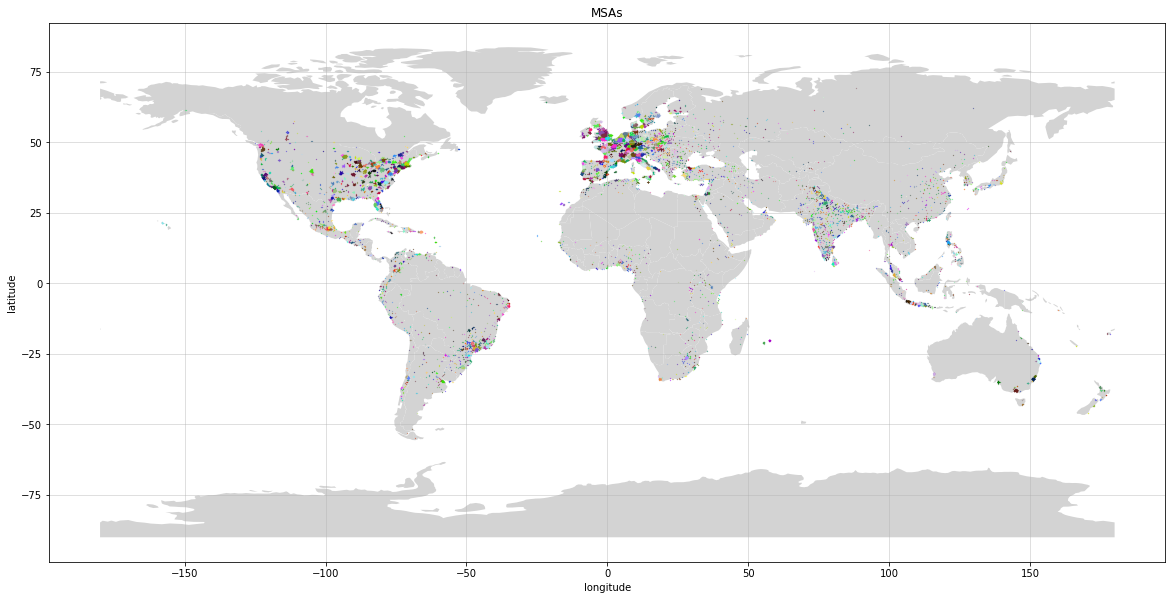

In [35]:
num_diff_colors = 300
colors_ = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = colors_(num_diff_colors)
plot_clusters(res_msa, colors, "MSAs")

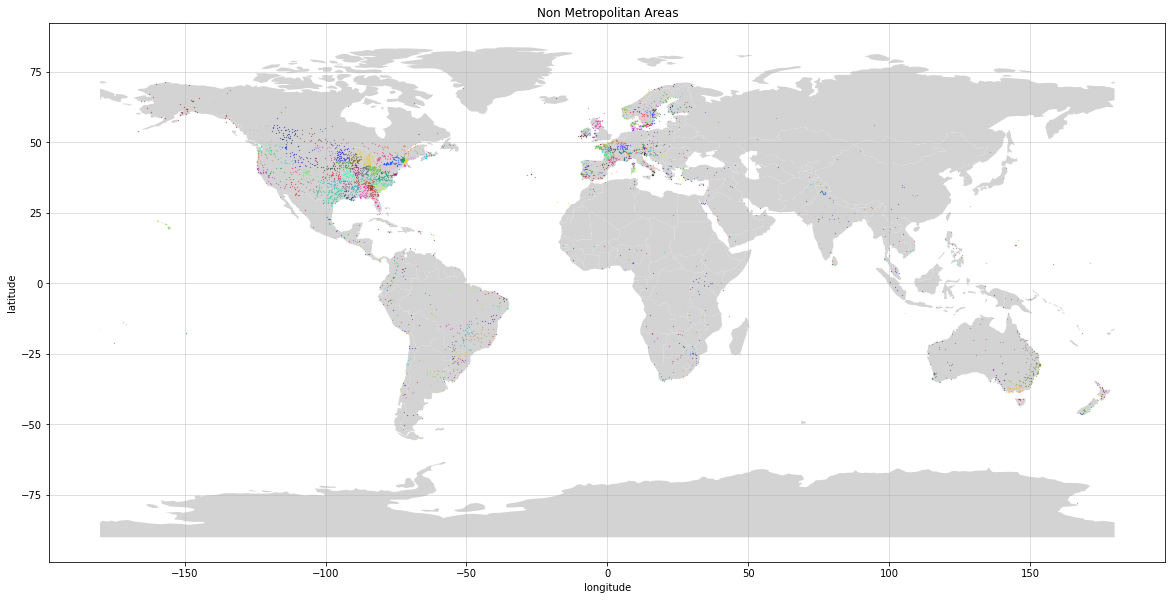

In [36]:
num_diff_colors = 300
colors_ = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = colors_(num_diff_colors)
plot_clusters(res_non_msa, colors, "Non Metropolitan Areas")

## Below we will check how well our clustering does in aligning with the labeled MSAs vs how a baseline out of the box clustering algorithm performs (just for comparison purposes)

- We will used Rand Index to check the similarity between the labeled clustering and our custom algorithm vs a baseline DBScan algorithm

In [37]:
usa = res_copy[res_copy.country == 'united states'].dropna()
usa = usa[usa['new_msa'].str.contains('MSA')].copy() ## measure against predicted msas; thats the only thing we cluster
usa

,level_0,lat_lon,pred,index,old_index,city,state,country,latitude,longitude,population,msa,new_msa
0,0,"41.37232,-73.73346",1,0,0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...,united states__new york__new york city__MSA
2,3,"42.31346,-122.96699",1,6,7,jacksonville,oregon,united states,42.31346,-122.96699,2883,Jacksonville FL MSA,united states__oregon__medford__MSA
3,4,"35.06845,-82.36845",1,13,15,tigerville,south carolina,united states,35.06845,-82.36845,1312,Greenville-Mauldin-Easley SC MSA,united states__north carolina__asheville__MSA
4,6,"40.17365,-85.49414",1,26,29,yorktown,indiana,united states,40.17365,-85.49414,11231,Muncie IN MSA,united states__indiana__indianapolis__MSA
5,7,"41.6331,-72.4547",1,30,34,marlborough,connecticut,united states,41.63310,-72.45470,6368,Hartford-West Hartford-East Hartford CT MSA,united states__massachusetts__springfield__MSA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,7478,"33.73205,-84.91911",1,25404,32093,villa rica,georgia,united states,33.73205,-84.91911,14904,Atlanta-Sandy Springs-Marietta GA MSA,united states__georgia__atlanta__MSA
5541,7479,"32.56319,-97.14168",1,25405,32094,mansfield,texas,united states,32.56319,-97.14168,64274,Mansfield OH MSA,united states__texas__dallas__MSA
5542,7481,"43.06308,-83.85107",1,25407,32096,flushing,michigan,united states,43.06308,-83.85107,8086,Wheeling WV-OH MSA,united states__michigan__lansing__MSA
5543,7482,"33.80816,-84.1702",1,25408,32097,stone mountain,georgia,united states,33.80816,-84.17020,6109,Atlanta-Sandy Springs-Marietta GA MSA,united states__georgia__atlanta__MSA


In [38]:
l = len(usa[~usa['new_msa'].str.contains('MSA')])
print(f"Print true if all cities predicted to be in an MSA are labeled as such: {0 == l}")

Print true if all cities predicted to be in an MSA are labeled as such: True


All predicted MSAs are also ground truth MSAs from our data so we don't need to worry about mismatch cases for rand score index. Remember, we only cluster examples predicted to be MSAs so measuring using rand index will be simple. We are measuring ONLY cluster algorithm alignment with ground truth MSAs, not the steps that predict which cities are in an MSA.

In [39]:
from sklearn.metrics import rand_score
y_true = usa.msa.astype('category').cat.codes
y_pred = usa.new_msa.astype('category').cat.codes

print(f"Custom clustering rand index: {rand_score(y_true, y_pred)}")

Custom clustering rand index: 0.9847318636140967


The rand index value was extremely close to 1 so that shows that our clustering is not far off. Let's measure how DBScan would do for various values of `max_distance`

In [40]:
from sklearn.cluster import DBSCAN

scores_per_epsilon = []
for max_distance in [0.5,1,2,5,10,50,100]:
    epsilon = max_distance / 3956 ## conversion for miles
    X_rads = np.radians(usa[['latitude','longitude']])

    db = DBSCAN(
        eps=epsilon, 
        min_samples=1, 
        algorithm='ball_tree', 
        metric='haversine'
    ).fit(X_rads)

    print(f"rand score for max_distance={max_distance} miles = {rand_score(y_true, db.labels_)}")

rand score for max_distance=0.5 miles = 0.9809621955002121
rand score for max_distance=1 miles = 0.9809673520442963
rand score for max_distance=2 miles = 0.9811426745431575
rand score for max_distance=5 miles = 0.9852388456529162
rand score for max_distance=10 miles = 0.9153436875696818
rand score for max_distance=50 miles = 0.6609207400109538
rand score for max_distance=100 miles = 0.33712086704944894


## We see that for some values of baseline DBScan, the Rand Index is slightly higher than our clustering. This is okay though since a rand index of 0.985 for our clustering is quite high. 
- We also know that our system has intentional deviation from the actual MSAs by design of the 50 mile max radius from largest city in cluster limit so aiming for a perfect score of 1 is not reasonable
- Our sanity check shows our clustering is not too far off from the old MSAs. We also know that other clustering algorithms can be used to reach some alignment with the MSA system but we stick to ours due to its favorable properties